In [1]:
# import all needed packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [2]:
# import the data and turn into dataframe 
fake_news_data = pd.read_csv('../raw_data/train.csv')

In [3]:
# This is the feild that we are interseted in 
fake_news_data['statement'].head()

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object

In [4]:
# the statement feild does not show the full text so, we use set_option to get full text. 
pd.set_option("display.max_colwidth", None)

In [5]:
fake_news_data['statement'].head()

0                                                               Says the Annies List political group supports third-trimester abortions on demand.
1    When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
2                                        Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
3                                                                   Health care reform legislation is likely to mandate free sex change surgeries.
4                                                                                           The economic turnaround started at the end of my term.
Name: statement, dtype: object

In [6]:
fake_news_data['statement'] = fake_news_data['statement'].str.lower()

In [7]:
# replace "pants-fire", "barely-true" to "false"
fake_news_data['label'] = fake_news_data['label'].replace(['pants-fire', 'barely-true'],'false')
fake_news_data['label'].value_counts()

label
false          5100
half-true      2361
mostly-true    2213
true           1845
Name: count, dtype: int64

In [8]:
# replace "half-true", "mostly-true" to "true"
fake_news_data['label'] = fake_news_data['label'].replace(['half-true', 'mostly-true'],'true')
fake_news_data['label'].value_counts()

label
true     6419
false    5100
Name: count, dtype: int64

In [9]:
fake_news_data[fake_news_data.duplicated()]
fake_news_data = fake_news_data.drop_duplicates()

In [10]:
fake_news_data['statement'] = fake_news_data['statement'].replace(r'[^\s\w0-9]', '', regex=True)

In [11]:
# some of the states had missed spelled state name or in different format so we change them to same.
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["District of Columbia", "Washington D.C.", "Washington, D.C.", "Washington DC"], "Washington D.C.")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Tex", "Texas"], "Texas")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Washington", "Washington state"], "Washington")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Virginia", "Virgina", "Virgiia"], "Virginia")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Pennsylvania", "PA - Pennsylvania"], "Pennsylvania")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Rhode Island", "Rhode island"], "Rhode Island")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Ohio", "ohio"], "Ohio")
fake_news_data['state_info'] = fake_news_data['state_info'].replace(["Tennessee", "Tennesse"], "Tennessee")

In [12]:
us_state = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois',
            'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana',
            'Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon',
            'Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia',
            'Wisconsin','Wyoming','District of Columbia', 'Washington, D.C.']

fake_news_data = fake_news_data[fake_news_data['state_info'].isin(us_state)]

In [13]:
fake_news_data['num_label'] = fake_news_data['label'].replace({'false' : 0, 'true' : 1})

C:\Users\17326\AppData\Local\Temp\ipykernel_23468\1966270977.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fake_news_data['num_label'] = fake_news_data['label'].replace({'false' : 0, 'true' : 1})


In [14]:
fake_news_data.head()

,ID,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,barely_true_counts,false_counts,...,sentiment_magnitude,anger,fear,joy,disgust,sad,speaker_id,list,sentiment_code,num_label
0,2635.json,false,says the annies list political group supports thirdtrimester abortions on demand,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0.5,0.121137,0.008926,0.026096,0.263479,0.531887,_0_,"[0, 1]",_NEG_,0
1,10540.json,true,when did the decline of coal start it started when natural gas took off that started to begin in president george w bushs administration,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0.8,0.095352,0.124566,0.191357,0.016999,0.102045,_1_,"[0, 1]",_NEG_,1
2,324.json,true,hillary clinton agrees with john mccain by voting to give george bush the benefit of the doubt on iran,foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,0.3,0.039559,0.024162,0.500384,0.454228,0.052453,_2_,"[1, 0]",_NEG_,1
4,9028.json,true,the economic turnaround started at the end of my term,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,0.0,0.044237,0.215996,0.222402,0.045672,0.274343,_4_,"[0, 1]",NaN,1
5,12465.json,true,the chicago bears have had more starting quarterbacks in the last 10 years than the total number of tenured uw faculty fired during the last two decades,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,...,0.3,0.044534,0.037243,0.294698,0.035936,0.598971,_5_,"[1, 0]",_NEG_,1


In [15]:
# Select features and target
X = fake_news_data['statement']
y = fake_news_data['num_label']

vectorization = CountVectorizer(min_df=60, stop_words='english')
vectorization2 = TfidfVectorizer(min_df=60, stop_words='english')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# using CountVectorizer
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

# using TfidfVectorizer
xv_train2 = vectorization2.fit_transform(X_train)
xv_test2 = vectorization2.transform(X_test)

In [16]:
### After evalutaing models like CatBoost, RandomForset we seleceted LogisticRegression as the final model. ###

In [17]:
model = LogisticRegression()
model.fit(xv_train2, y_train)
y_pred = model.predict(xv_test)

In [18]:
# fbeta_score with more focus on recall. don’t miss real fake news 
fbeta_score(y_test, y_pred, average='micro', beta=2) 

0.601699716713881

In [19]:
model.fit(xv_train2, y_train)
y_predd = model.predict(xv_test2)
fbeta_score(y_test, y_predd, average='micro', beta=0.5)

0.6

In [20]:
confusion_matrix(y_test, y_pred)

array([[277, 493],
       [210, 785]], dtype=int64)

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44       770
           1       0.61      0.79      0.69       995

    accuracy                           0.60      1765
   macro avg       0.59      0.57      0.57      1765
weighted avg       0.59      0.60      0.58      1765



In [22]:
# cross-validatation for LogisticRegression
cv_results = cross_validate(model, xv_train2, y_train, cv=5)

In [23]:
cv_scores = cv_results['test_score']
cv_scores

array([0.601983  , 0.59490085, 0.58711048, 0.59915014, 0.60269122])

In [24]:
np.mean(cv_scores), np.std(cv_scores)

(0.5971671388101983, 0.005725604229860562)

In [25]:
# finding the best hyper parameters for LogisticRegression
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.01, 0.1, 1, 10],
              'max_iter': [100, 200, 500],
              'solver': ['saga']}
    
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(xv_train2, y_train)

C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\17326\Documents\temp\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1204, 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga']},
             scoring='roc_auc')

In [26]:
print(grid_search.best_params_)

{'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}


In [27]:
lr_new = LogisticRegression(C = 0.1, max_iter = 500, penalty = 'l2', solver = 'saga')
lr_new.fit(xv_train2, y_train)
lr_new.score(xv_test2, y_test)

0.5875354107648725

In [28]:
# finding the thershold, precision, recall.
yprob = model.predict_proba(xv_test)
yprob = yprob[:, 1]

In [29]:
# The AUC score is above 0.5 which means the predicts are not random. The model is trying to predict the correct labels. 
roc_auc_score(y_test, yprob)

0.6106049729165307

In [30]:
# classification report which shows the affect of decearsing the threshold.
print(classification_report(y_test, np.array(yprob) > 0.3))

              precision    recall  f1-score   support

           0       0.62      0.10      0.18       770
           1       0.58      0.95      0.72       995

    accuracy                           0.58      1765
   macro avg       0.60      0.53      0.45      1765
weighted avg       0.60      0.58      0.48      1765



In [31]:
# classification report which shows the affect of incerasing the threshold
print(classification_report(y_test, np.array(yprob) > 0.7))

              precision    recall  f1-score   support

           0       0.50      0.70      0.58       770
           1       0.66      0.46      0.54       995

    accuracy                           0.56      1765
   macro avg       0.58      0.58      0.56      1765
weighted avg       0.59      0.56      0.56      1765



In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, yprob)
thresholds = np.append(thresholds, 1)

In [33]:
# calcuating the f1_score 
one = 2*precision * recall
two = precision + recall 
f1 = one / two 

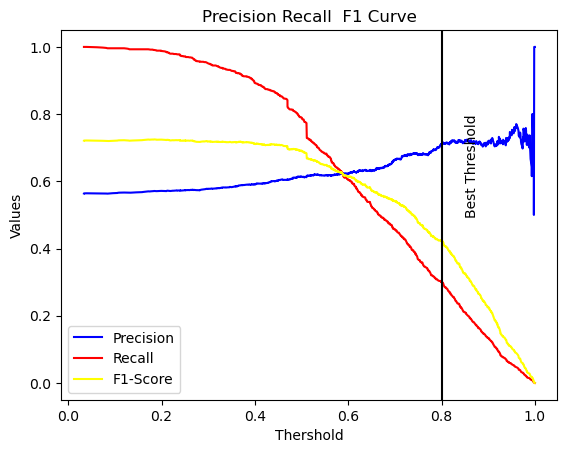

In [34]:
# BUSINESS CASE 1

# Ploting thershold, precision, recall for CountVectorizer 
# 0.80 is good for this case.
# we are putting more focus on precision 
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, f1, color='yellow')
plt.xlabel('Thershold')
plt.ylabel('Values')
plt.title('Precision Recall  F1 Curve')
plt.axvline(x=.80, color='black')
plt.text(.85,.50,'Best Threshold',rotation=90)
plt.legend(('Precision', 'Recall', 'F1-Score'))

In [35]:
# finding the thershold, precision, recall.
yprob = model.predict_proba(xv_test2)
yprob = yprob[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, yprob)
thresholds = np.append(thresholds, 1)

In [36]:
one = 2*precision * recall
two = precision + recall 
f1 = one / two 

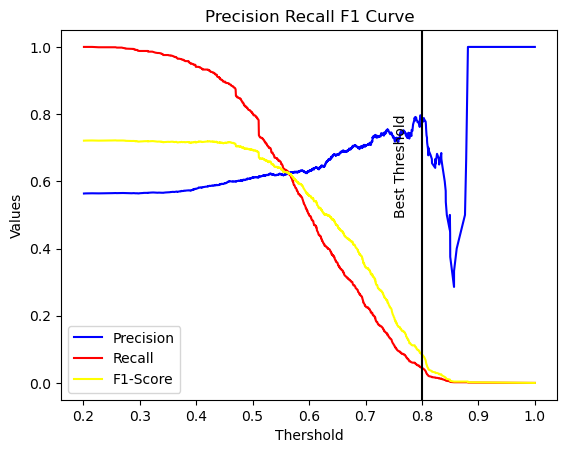

In [37]:
# Ploting thershold, precision, recall for TfidfVectorizer 
# 0.80 is good thershold 

plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, f1, color='yellow')
plt.xlabel('Thershold')
plt.ylabel('Values') 
plt.title('Precision Recall F1 Curve')
plt.axvline(x=.80, color='black')
plt.text(.75,.50,'Best Threshold',rotation=90)
plt.legend(('Precision', 'Recall', 'F1-Score'))

In [100]:
# BUSINESS CASE 2 
balanced_accuracies = []
for t in thresholds:
    y_pred = (yprob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Avoid division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    balanced_accuracy = (recall + specificity) / 2
    balanced_accuracies.append(balanced_accuracy)

Text(0.5, 1.0, 'Balanced Accuracy  vs. Threshold')

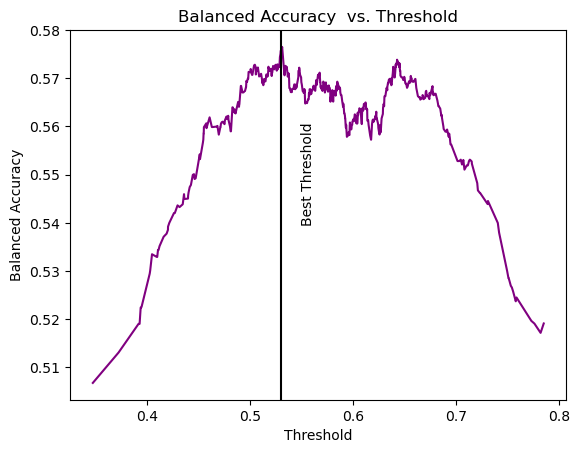

In [126]:
plt.plot(thresholds, balanced_accuracies, label='Balanced Accuracy', color='purple')
plt.axvline(x=.53, color='black')
plt.text(.55,.54,'Best Threshold',rotation=90) 
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy  vs. Threshold')

In [108]:
y_prob2 = grid_search.predict_proba(xv_test)[:,1]

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob2)

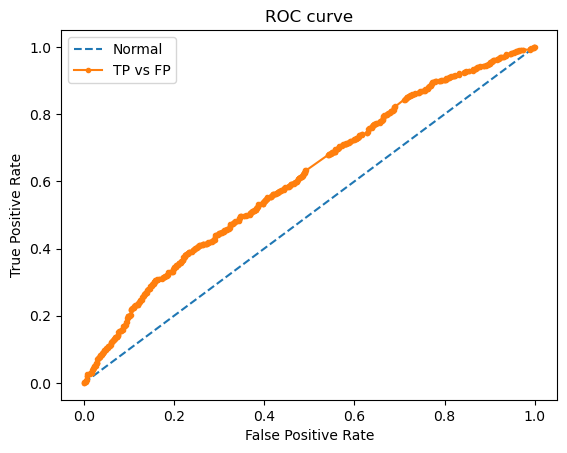

In [42]:
# ROC Curve for CountVectorizer
plt.plot([0,1], [0,1], linestyle='--', label='Normal')
plt.plot(fpr, tpr, marker='.', label='TP vs FP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')

plt.show()

In [43]:
# find the best thershold. Ploting the FP vs TP to for TfidfVectorizer model 
yprob = model.predict_proba(xv_test2)
yprob = yprob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, yprob)

In [44]:
y_prob2 = grid_search.predict_proba(xv_test2)[:,1]

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob2)

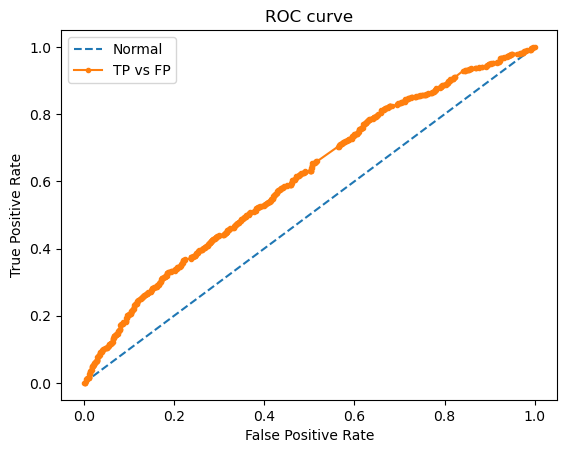

In [46]:
# ROC Curve for TfidfVectorizer
plt.plot([0,1], [0,1], linestyle='--', label='Normal')
plt.plot(fpr, tpr, marker='.', label='TP vs FP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')

plt.show()